# Detectando Capacetes de Segurança

## Código

In [1]:
import io
import json
import boto3

from IPython.display import display
from IPython.display import Image as IIPImage
from PIL import Image, ImageDraw, ExifTags, ImageColor

In [2]:
session = boto3.session.Session()
s3 = session.client('s3')
BUCKET_NAME = 'solvimm-object-recognition-demo-87698756'
_ = s3.create_bucket(Bucket=BUCKET_NAME)
_ = !aws s3 sync ./img/ s3://$BUCKET_NAME/img/

In [6]:
class RekognitionHelper:
    
    def __init__(self, client, bucket_name, s3_resource):
        self.client = client
        self.bucket_name = bucket_name
        self.s3_resource = s3_resource
        self.image = None
    
    
    def rekognition_detect_labels(self, name, bucket_name=''):
        response = None
        try:
            if bucket_name == '':
                bucket_name = self.bucket_name
                
            response = self.client.detect_labels(
                Image={
                    'S3Object': {
                        'Bucket': bucket_name,
                        'Name': name
                    }
                }
            )
        except Exception as e:
            print(e)
        return response 
    
    
    def set_box(self, box):
        self.box = box
        
        
    def s3_get_object(self, path):
        s3_object = self.s3_resource.Object(self.bucket_name, path)
        self.s3_response = s3_object.get()
        return self.s3_response

    
    def  s3_get_object_stream(self, path):
        s3_response = self.s3_get_object(path)
        self.stream = io.BytesIO(s3_response['Body'].read())
        return self.stream 
    
    
    def load_image(self, path):
        if self.image is None:
            self.stream = self.s3_get_object_stream(path)
            self.image = Image.open(self.stream)
            self.draw = ImageDraw.Draw(self.image) 
            self.img_width, self.img_height = self.image.size  
    
    
    def load_box_points(self):
        self.left = self.img_width * self.box['Left']
        self.top = self.img_height * self.box['Top']
        self.width = self.img_width * self.box['Width']
        self.height = self.img_height * self.box['Height']

        self.points = (
            (self.left, self.top),
            (self.left + self.width, self.top),
            (self.left + self.width, self.top + self.height),
            (self.left , self.top + self.height),
            (self.left, self.top)

        )
    
   
    def draw_box(self, color='#00d400', width=2):
        self.draw.line(self.points, fill=color, width=width)
       
    
    def display_image(self):
        display(self.image)
    
    
    def clean_image(self):
        self.image = None
        self.point= None

In [7]:
client = session.client('rekognition')
s3_resource = boto3.resource('s3')

rekognition = RekognitionHelper(client, BUCKET_NAME, s3_resource)

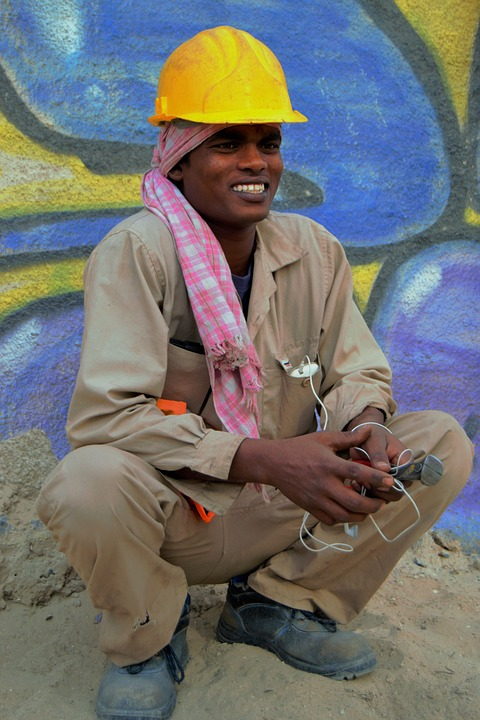

Name: Clothing Confidence 99.8621826171875
Name: Apparel Confidence 99.8621826171875
Name: Human Confidence 97.53600311279297
Name: Person Confidence 97.53600311279297
Name: Helmet Confidence 97.06925964355469
Name: Hardhat Confidence 87.993896484375
Name: Shoe Confidence 79.57534790039062
Name: Footwear Confidence 79.57534790039062
Name: Wood Confidence 58.3265380859375
Name: Hat Confidence 56.15650939941406


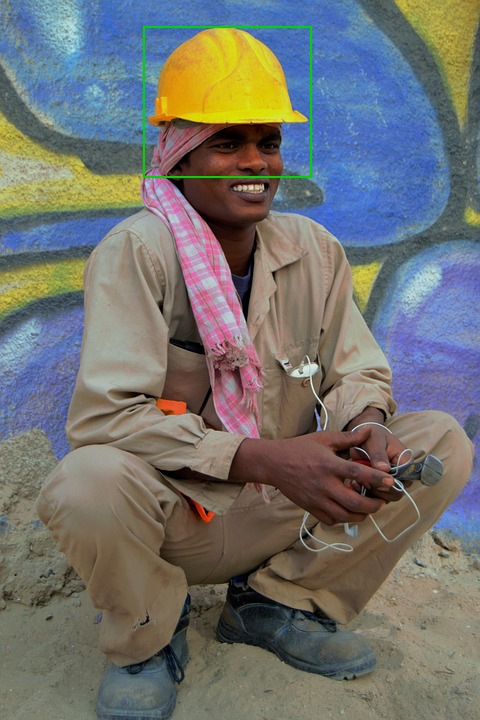

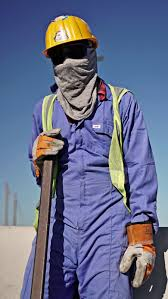

Name: Apparel Confidence 99.41702270507812
Name: Clothing Confidence 99.41702270507812
Name: Person Confidence 97.14740753173828
Name: Human Confidence 97.14740753173828
Name: Helmet Confidence 93.01167297363281
Name: Hardhat Confidence 89.94939422607422
Name: Worker Confidence 70.68099212646484
Name: Outdoors Confidence 61.096134185791016
Name: Vest Confidence 56.431556701660156


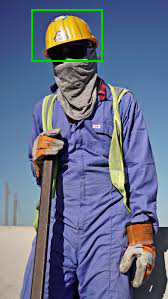

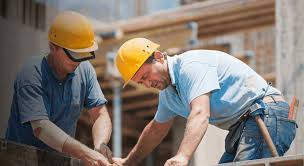

Name: Human Confidence 99.22103881835938
Name: Person Confidence 99.22103881835938
Name: Apparel Confidence 97.65164947509766
Name: Helmet Confidence 97.65164947509766
Name: Hardhat Confidence 97.65164947509766
Name: Clothing Confidence 97.65164947509766
Name: Carpenter Confidence 79.81644439697266
Name: Worker Confidence 79.7965316772461
Name: Construction Confidence 79.19432067871094
Name: People Confidence 63.842124938964844
Name: Arm Confidence 56.480567932128906


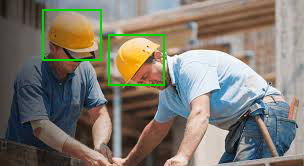

In [9]:
for id in range(1, 4):
    path = 'img/{}.jpg'.format(id)
    img = IIPImage(path)
    display(img)

    response = rekognition.rekognition_detect_labels(path)

    for r in response['Labels']:
         print('Name: {} Confidence {}'.format(r['Name'], r['Confidence']))

    for l in response['Labels']:
        if l['Instances'] and (l['Name'] == 'Helmet' or l['Name'] == 'Hardhat'):

            for bb in l['Instances']:
                box = bb['BoundingBox']
                rekognition.set_box(box)
                rekognition.load_image(path)
                rekognition.load_box_points()
                rekognition.draw_box()
    rekognition.display_image()
    rekognition.clean_image()

## Links

- https://docs.aws.amazon.com/rekognition/latest/dg/images-displaying-bounding-boxes.html